# Terra em Foco Conference: Introduction to Sentinel Hub APIs in CDSE: Part Two

*This notebook was written for a two hour training session at the Terra em Foco, the Portuguese Earth Observation National Conference held in Braga, Portugal 12-13th September 2024.*

The Copernicus Data Space Ecosystem offers immediate access to large amounts of open and free Earth observation data from the Copernicus Sentinel satellites, including both new and historical Sentinel images, as well as Copernicus Contributing Missions. As the effects of climate change intensifies, the use of earth observation data will become ever more important to monitor wildfires in the southern Europe including Portugal. These two notebooks will show how you can utilise Copernicus data to do just this.

The Copernicus Data Space Ecosystem supports users in accessing, viewing, using, downloading, and analyzing data. The Copernicus Data Space Ecosystem is set up to further improve access and exploitation of the EU’s Copernicus satellites data. The service aims to support users in building various applications needed to provide accurate, timely and objective information which are crucial to create a more sustainable future.

The Copernicus Data Space Ecosystem offers multiple Application Programming Interfaces (APIs) ranging from catalogue, product download, visualization over processing web services such as STAC, openEO and Sentinel Hub APIs. This Jupyter notebook focuses on the Sentinel Hub APIs The Sentinel Hub API is a RESTful API interface that provides access to various satellite imagery archives. It allows you to access raw satellite data, rendered images, statistical analysis, and other features.

You will be shown how to:

- Monitor the recovery of vegetation post event visually
- Delineate and then polygonise the burn scar using Process API and Python
- Use the polygon to create to create time series of vegetation indices.

**Note:** You should already have some experience of Sentinel Hub APIs to be able to follow the functions in this notebook. You can begin by going through part one of the workshop. However, it is advised that you should have some basic knowledge of python and its data science libraries.

Firstly, before getting started we should import some libraries. In addition, to common data science libraries we will be utilising the [Sentinel Hub Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). This comes preinstalled in the Copernicus Data Space Ecosystem Jupyter Lab. 

In [1]:
# General utilities
import getpass
import warnings
from pathlib import Path
from typing import Any, Optional, Tuple
import datetime

# Plotting
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Reading satellite imagery
import rasterio as rio
from matplotlib import colors
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject
from rasterio.features import shapes
from rasterio.features import sieve

# Sentinel Hub services
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
    SentinelHubDownloadClient,
)
from shapely.geometry import shape

warnings.filterwarnings("ignore")
%matplotlib inline

In the following cell, we have defined some python functions to help us process and visualise the data later on in the notebook:

In [2]:
def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any,
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


def vectorize_raster(raster_path, vector_path):
    with rio.open(raster_path) as src:
        raster_data = src.read(1)  # read only the first band
        transform = (
            src.transform
        )  # to convert pixel coordinates to geographic coordinates
        crs = src.crs

    shapes_generator = shapes(
        raster_data, transform=transform
    )  # add mask=raster_data != 0 to exclude nodata values

    vector_data = [
        {"properties": {"value": value}, "geometry": shape}
        for shape, value in shapes_generator
    ]

    gdf = gpd.GeoDataFrame.from_features(vector_data, crs=crs)
    # save to file
    # gdf.to_file(vector_path, driver="GeoJSON")
    return gdf

def rio_resample(method):
    """Return a rasterio resampling method based on a string."""

    resampling_methods = {
        "nearest": rio.enums.Resampling.nearest,
        "bilinear": rio.enums.Resampling.bilinear,
        "cubic": rio.enums.Resampling.cubic,
        "cubic_spline": rio.enums.Resampling.cubic_spline,
        "lanczos": rio.enums.Resampling.lanczos,
        "average": rio.enums.Resampling.average,
        "mode": rio.enums.Resampling.mode,
        "gauss": rio.enums.Resampling.gauss,
        "max": rio.enums.Resampling.max,
        "min": rio.enums.Resampling.min,
        "med": rio.enums.Resampling.med,
        "q1": rio.enums.Resampling.q1,
        "q3": rio.enums.Resampling.q3,
        "sum": rio.enums.Resampling.sum,
        "rms": rio.enums.Resampling.rms,
    }

    if method not in resampling_methods:
        raise ValueError(
            "Wrong resampling method selected."
            " See: https://rasterio.readthedocs.io/en/latest/api/rasterio.enums."
            "html#rasterio.enums.Resampling"
        )

    return resampling_methods[method]


def reproject_raster(inpath, outpath, crs, method="nearest"):
    "Reproject a raster to a new coordinate system."

    dst_crs = f"EPSG:{crs}"

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )

        with rio.open(outpath, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=rio_resample(method),
                )

def resample_rasters(filenames, upscale_factor, output_path, method="nearest"):
    """Resample list of rasters."""
    output_files = []

    for file in filenames:
        src = rio.open(file)

        # resample data to target shape
        data = src.read(
            out_shape=(
                src.count,
                int(src.height * upscale_factor),
                int(src.width * upscale_factor),
            ),
            resampling=rio_resample(method),
        )

        # scale image transform
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]), (src.height / data.shape[-2])
        )

        # Save rasters
        output_files.append(f"{output_path}/{Path(file).stem}_resampled.tiff")
        write_raster(
            f"{output_path}/{Path(file).stem}_resampled.tiff",
            data[0, :, :],
            src.profile["crs"],
            transform,
            65535,
        )

    return output_files
    
def write_raster(path, raster, crs, transform, nodata, driver="GTiff"):
    """Write a raster to a file."""

    with rio.open(
        path,
        "w",
        driver=driver,
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,
        dtype=raster.dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
    ) as dst:
        dst.write(raster, 1)


# define functions to extract statistics for all acquisition dates


def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

## Authentication

You can obtain the credentials for the Sentinel Hub services (`client_id` & `client_secret`) in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the user settings, you can create a new OAuth client to generate these credentials. You can find more detailed instructions on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions for configuring your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions, you can create a profile specifically tailored to use the package to access the Copernicus Data Space Ecosystem data collections. This is useful because changes to the Config class in your notebook are usually only temporary. If you save the configuration in your profile, you do not have to generate new credentials or overwrite/change the default profile every time you start or write a new Jupyter notebook.

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [3]:
# Only run this cell if you have not created a configuration.

#config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
#config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
#config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

Enter your SentinelHub client id ········
Enter your SentinelHub client secret ········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [4]:
config = SHConfig("cdse")

We are in a new notebook so we need to redefine our AOI here:

In [5]:
area_of_interest = """{
  "type": "Polygon",
  "coordinates": [
    [
      [
        -8.920627,
        37.362517
      ],
      [
        -8.516631,
        37.362517
      ],
      [
        -8.516631,
        37.628372
      ],
      [
        -8.920627,
        37.628372
      ],
      [
        -8.920627,
        37.362517
      ]
    ]
  ]
}
"""

aoi = gpd.read_file(area_of_interest)
aoi["geometry"] = aoi
aoi["area"] = aoi.area
aoi.explore("area", color="Green", legend=False)

## 4: Monitoring the recovery of vegetation post event

In [6]:
start = datetime.datetime(2023, 8, 10)
end = datetime.datetime(2024, 7, 10)
n_chunks = 10
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Time windows:\n")
for slot in slots:
    print(slot)

Time windows:

('2023-08-10', '2023-09-12')
('2023-09-12', '2023-10-16')
('2023-10-16', '2023-11-18')
('2023-11-18', '2023-12-22')
('2023-12-22', '2024-01-24')
('2024-01-24', '2024-02-27')
('2024-02-27', '2024-03-31')
('2024-03-31', '2024-05-04')
('2024-05-04', '2024-06-06')


In [7]:
full_geometry = Geometry(aoi.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

evalscript_swir_composite = """
//VERSION=3
function setup() {
  return {
    input: ["B12","B8A","B04", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  return [sample.B12,sample.B8A,sample.B04, sample.dataMask ];
}
"""


def get_swir_composite_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_swir_composite,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=time_interval,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=full_geometry,
        size=[1000, 920],
        config=config,
    )

In [8]:
# create a list of requests
list_of_requests = [get_swir_composite_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

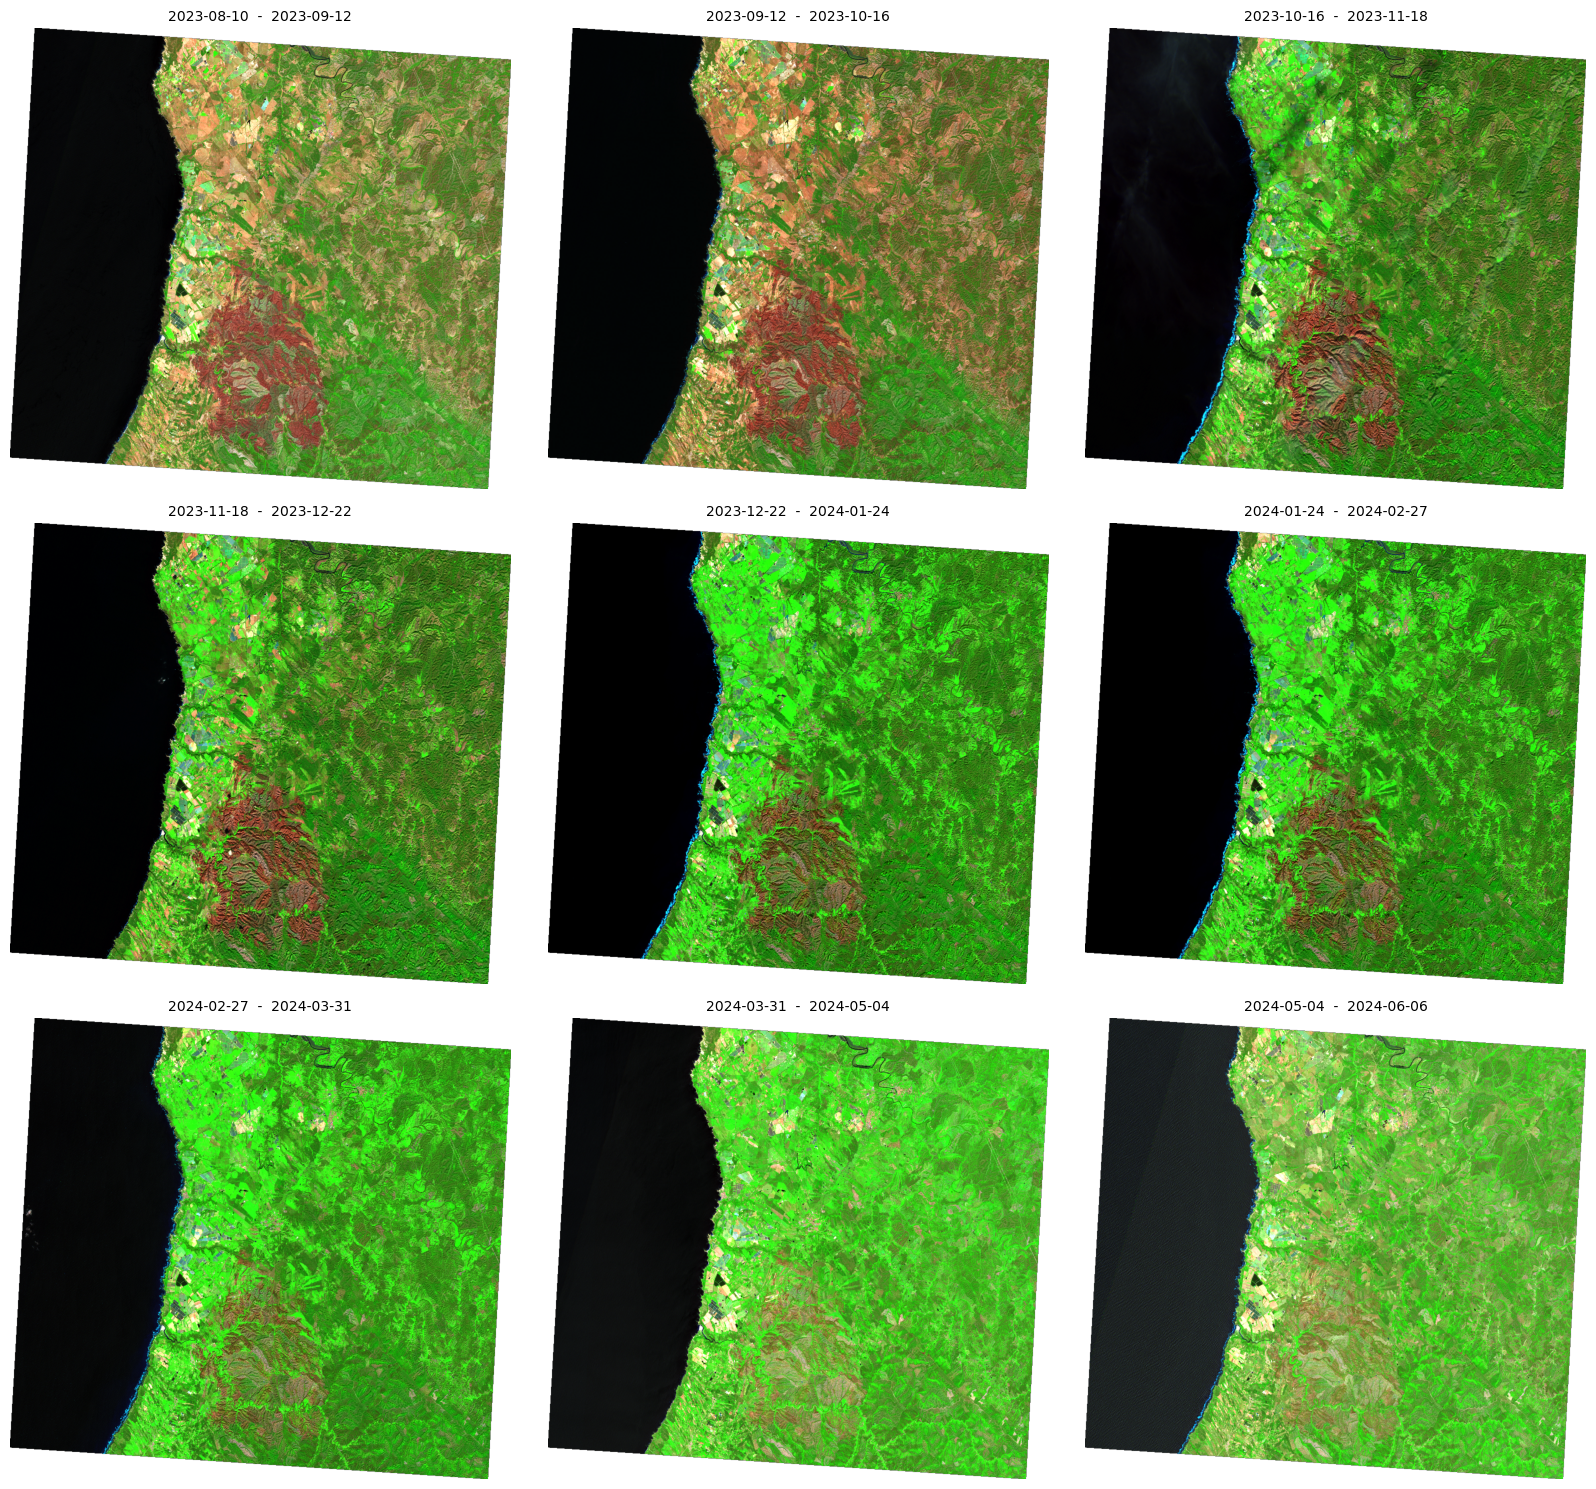

In [9]:
# some stuff for pretty plots
ncols = 3
nrows = 3
aspect_ratio = 1000 / 920
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

## 5. Delineate and then polygonize the burn scar

In [10]:
# Set the directory where results will be stored
results_dir = "./data"

In [11]:
evalscript_burn_scar_detection = """
//VERSION=3
// Burneed area detection
// Author: Monja B. Šebela

function setup() {
    return {
        input: ["B02", "B03", "B04", "B08", "B11", "B12", "dataMask"],
        output: { bands: 3, sampleType:"UINT8" }
      };
}

function evaluatePixel(samples) {
	var NDWI=index(samples.B03, samples.B08); 
	var NDVI=index(samples.B08, samples.B04);
	var INDEX= ((samples.B11 - samples.B12) / (samples.B11 + samples.B12))+(samples.B08);

  	if((INDEX>0.2)||(samples.B02>0.1)||(samples.B11<0.1)||(NDVI>0.3)||(NDWI > 0.1)){
  		return[0,0,0]
	}
	else {
 	return[1,1,1]
	}
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_burn_scar_detection,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2023-08-12", "2023-08-12"),
            other_args={"dataFilter": {"mosaickingOrder": "leastRecent"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    geometry=full_geometry,
    size=[1000, 920],
    data_folder=results_dir,
    config=config,
)

The method `get_data()` will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [ ]:
sh_request = request.get_data(save_data=True)

#### Clean up the burn scar

One of the limitations of Sentinel Hub services is that it fumctions on a per-pixel basis. Therefore to perform a morphological operation on the results we will open the raster and apply the last step on the downloaded file.

We then open the raster with `rasterio` and clean the data as we did in the "traditional" approach. We save the output, as well as the reprojected version to be able to plot the data interactively.

In [9]:
burn_scar_raster = request.get_filename_list()

NameError: name 'request' is not defined

Next, we can sieve the raster to remove noise from the result:

In [35]:
burn_scar = rio.open(f"data/%s" % burn_scar_raster[0])

burn_scar_cleaned = sieve(burn_scar, size=400)

# Save the output
write_raster(
    f"{results_dir}/burn_area.tif",
    burn_scar_cleaned.astype("uint8"),
    burn_scar.crs,
    burn_scar.transform,
    0,
)

# Reproject to EPSG 4326
reproject_raster(
    f"{results_dir}/burn_area.tif",
    f"{results_dir}/burn_area_4326.tif",
    3857,
    method="nearest",
)

burn_scar.close()

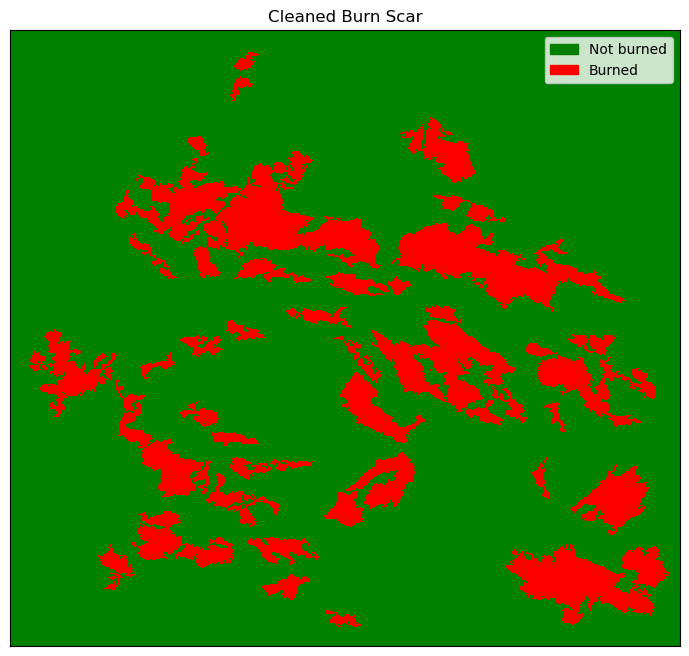

In [36]:
cmap_burn_scar = colors.ListedColormap(["green", "red"])
bounds_burn_scar = [0, 0.5, 1]
norm_burn_scar = colors.BoundaryNorm(bounds_burn_scar, cmap_burn_scar.N)

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(burn_scar_cleaned, cmap=cmap_burn_scar, norm=norm_burn_scar)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        mpatches.Patch(color="green", label="Not burned"),
        mpatches.Patch(color="red", label="Burned"),
    ]
)
ax.set_title("Cleaned Burn Scar")

plt.show()

Once happy with the result, we can vectorise the raster so that we can use it as an input in the next step in the workflow.

In [15]:
raster_path = "data/burn_area_4326.tif"
vector_path = "data/vectorized.geojson"

burn_scar = vectorize_raster(raster_path, vector_path)

If we examine the burn scar vector, we can currently see that it is made up of several features. To simplify this we can dissolve it into a single Multipolygon feature.

In [16]:
burn_scar

geometry  value
0   POLYGON ((-972046.739 4507343.553, -972046.739...    1.0
1   POLYGON ((-969772.623 4505615.224, -969772.623...    1.0
2   POLYGON ((-973274.762 4507707.411, -973274.762...    1.0
3   POLYGON ((-973365.726 4504523.648, -973365.726...    0.0
4   POLYGON ((-973593.138 4504250.754, -973593.138...    1.0
5   POLYGON ((-973547.656 4504250.754, -973547.656...    0.0
6   POLYGON ((-973502.173 4501294.403, -973502.173...    1.0
7   POLYGON ((-974320.855 4501203.438, -974320.855...    1.0
8   POLYGON ((-968908.458 4500794.098, -968908.458...    0.0
9   POLYGON ((-968999.423 4500748.615, -968999.423...    0.0
10  POLYGON ((-966134.036 4500657.651, -966134.036...    1.0
11  POLYGON ((-965269.872 4499884.451, -965269.872...    1.0
12  POLYGON ((-964906.014 4499429.628, -964906.014...    0.0
13  POLYGON ((-974229.891 4499429.628, -974229.891...    0.0
14  POLYGON ((-972183.186 4498838.357, -972183.186...    1.0
15  POLYGON ((-965133.425 4498838.357, -965133.425...    0.0
16  POLYGON ((-972137.704 4497291.958, -972137.704...    1.0
17  POLYGON ((-974093.444 4497246.476, -974093.444...    1.0
18  POLYGON ((-972183.186 4497246.476, -972183.186...    1.0
19  POLYGON ((-965087.943 4497110.029, -965087.943...    0.0
20  POLYGON ((-965133.425 4497064.547, -965133.425...    0.0
21  POLYGON ((-968135.259 4496882.617, -968135.259...    1.0
22  POLYGON ((-973638.620 4495972.971, -973638.620...    1.0
23  POLYGON ((-973547.656 4495290.736, -973547.656...    0.0
24  POLYGON ((-965224.390 4495154.289, -965224.390...    0.0
25  POLYGON ((-965451.802 4494653.983, -965451.802...    1.0
26  POLYGON ((-965724.695 4494290.125, -965724.695...    0.0
27  POLYGON ((-969363.282 4494108.195, -969363.282...    0.0
28  POLYGON ((-974730.196 4493880.784, -974730.196...    1.0
29  POLYGON ((-963905.402 4493835.301, -963905.402...    0.0
30  POLYGON ((-972683.492 4493562.407, -972683.492...    0.0
31  POLYGON ((-974093.444 4499975.416, -974093.444...    1.0
32  POLYGON ((-969545.211 4505933.601, -969545.211...    1.0
33  POLYGON ((-970090.999 4493244.031, -970090.999...    1.0
34  POLYGON ((-995379.173 4529811.822, -995379.173...    0.0

In [17]:
burn_scar["area"] = burn_scar.area
burn_scar["area"]
burn_scar = burn_scar[burn_scar["value"] == 1.0]
burn_scar = burn_scar[burn_scar["area"] >= 0]
burn_scar = burn_scar.dissolve()
burn_scar

geometry  value          area
0  MULTIPOLYGON (((-969909.070 4493062.102, -9699...    1.0  78608.399912

In [18]:
burn_scar.explore("value", color="Green", legend=False)

Now we're ready to use the polygon as an input into a Statistical API request.

## 6. Plot an mean NDVI and mean Burn Ratio timeseries using the burnscar post event

We will do this using Statistical API. In the following request, we actually request two different indices in two seperate outputs.

In [19]:
full_geometry = Geometry(burn_scar.to_crs(32630).geometry.values[0], crs=CRS.UTM_30N)

In [24]:
yearly_time_interval = "2023-07-01", "2024-07-01"

ndvi_evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B04",
          "B06",
          "B07",
          "B08",
          "B8A",
          "B12",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "burnratio",
        bands: 1
      },  
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function evaluatePixel(samples) {

    return {
      ndvi: [index(samples.B08, samples.B04)],
      burnratio: [index(samples.B08, samples.B12)],
      dataMask: [samples.dataMask]
    };
    }
"""

aggregation = SentinelHubStatistical.aggregation(
    evalscript=ndvi_evalscript,
    time_interval=yearly_time_interval,
    aggregation_interval="P5D",
    resolution=(10, 10),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2", service_url=config.sh_base_url),
    other_args={"dataFilter": {"maxCloudCoverage": 10}},
)

ndvi_requests = []

request = SentinelHubStatistical(
    aggregation=aggregation,
    input_data=[input_data],
    geometry=full_geometry,
    config=config,
)
response1 = request.get_data()
response1

[{'data': [{'interval': {'from': '2023-07-01T00:00:00Z',
     'to': '2023-07-06T00:00:00Z'},
    'outputs': {'burnratio': {'bands': {'B0': {'stats': {'min': -0.5552912950515747,
         'max': 0.7225531935691833,
         'mean': 0.1953379045739073,
         'stDev': 0.16021334194684764,
         'sampleCount': 1279977,
         'noDataCount': 758349}}}},
     'ndvi': {'bands': {'B0': {'stats': {'min': -0.5226463079452515,
         'max': 0.9134020805358887,
         'mean': 0.5063815102282797,
         'stDev': 0.15952540787094904,
         'sampleCount': 1279977,
         'noDataCount': 758349}}}}}},
   {'interval': {'from': '2023-07-06T00:00:00Z', 'to': '2023-07-11T00:00:00Z'},
    'outputs': {'burnratio': {'bands': {'B0': {'stats': {'min': -0.5654853582382202,
         'max': 0.7235772609710693,
         'mean': 0.1781804743115865,
         'stDev': 0.16352270240364317,
         'sampleCount': 1279977,
         'noDataCount': 758349}}}},
     'ndvi': {'bands': {'B0': {'stats': {'m

In [25]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

date  burnratio_min  burnratio_max  burnratio_mean  burnratio_stDev  \
0  2023-07-01      -0.555291       0.722553        0.195338         0.160213   
0  2023-07-06      -0.565485       0.723577        0.178180         0.163523   
0  2023-07-11      -0.776824       0.728571        0.186536         0.160834   
0  2023-07-21      -0.583096       0.727541        0.200981         0.160402   
0  2023-07-26      -0.596361       0.724375        0.180899         0.165533   
0  2023-07-31      -0.710775       0.796337        0.190367         0.156237   
0  2023-08-05      -0.897051       0.564189       -0.247938         0.304680   
0  2023-08-10      -0.572002       0.539444       -0.230992         0.099872   
0  2023-08-15      -0.756383       0.582327       -0.278749         0.114919   
0  2023-08-20      -0.757772       0.552851       -0.269796         0.104621   
0  2023-08-25      -0.634544       0.566536       -0.265350         0.120948   
0  2023-08-30      -0.797945       0.543163       -0.273267         0.134134   
0  2023-09-29      -0.714719       0.512002       -0.299697         0.134322   
0  2023-10-04      -0.683119       0.509272       -0.318182         0.140847   
0  2023-11-23      -0.897801       0.808107       -0.183348         0.209387   
0  2023-12-08      -0.894737       0.844652       -0.112498         0.251599   
0  2023-12-28      -0.858164       0.842759       -0.050731         0.226811   
0  2024-01-22      -0.820225       0.846711        0.021014         0.240090   
0  2024-02-01      -0.932164       0.824351        0.044274         0.227121   
0  2024-02-26      -0.731141       0.786494        0.127652         0.215259   
0  2024-04-11      -0.682399       0.779954        0.172225         0.208225   
0  2024-04-21      -0.696517       0.769889        0.169673         0.197034   
0  2024-05-26      -0.662021       0.728147        0.067065         0.126995   
0  2024-05-31      -0.713075       0.709616        0.027711         0.119090   
0  2024-06-15      -0.785340       0.700353        0.030956         0.107459   
0  2024-06-20      -0.667925       0.687861       -0.006321         0.107134   

   ndvi_min  ndvi_max  ndvi_mean  ndvi_stDev  
0 -0.522646  0.913402   0.506382    0.159525  
0 -0.517583  0.913848   0.503602    0.161322  
0 -0.644809  0.927191   0.508390    0.167299  
0 -0.423651  0.920000   0.510282    0.159991  
0 -0.441008  0.917418   0.506618    0.164055  
0 -0.410405  0.951613   0.481705    0.162868  
0 -0.171725  0.784200   0.197600    0.183008  
0 -0.260126  0.802717   0.136891    0.059548  
0 -0.497823  0.884722   0.133032    0.064614  
0 -0.538841  0.825316   0.114035    0.056576  
0 -0.458065  0.875223   0.139275    0.060350  
0 -0.621795  0.869240   0.132925    0.062687  
0 -0.479755  0.851852   0.171364    0.063553  
0 -0.364929  0.866789   0.166138    0.068408  
0 -0.502415  1.000000   0.300841    0.152998  
0 -0.640327  1.000000   0.406940    0.191956  
0 -0.386782  1.000000   0.396491    0.187602  
0 -0.504587  1.000000   0.486249    0.193182  
0 -0.495227  0.992908   0.474432    0.190156  
0 -0.540702  0.972691   0.513743    0.191830  
0 -0.448845  0.943719   0.511844    0.190458  
0 -0.495758  0.940129   0.490177    0.181215  
0 -0.528998  0.905204   0.380705    0.135557  
0 -0.511504  0.897727   0.348135    0.128837  
0 -0.531016  0.914530   0.346266    0.126046  
0 -0.538972  0.896296   0.347033    0.123488

We can take this another step further, and display the data in a time series using the Matplotlib python library:

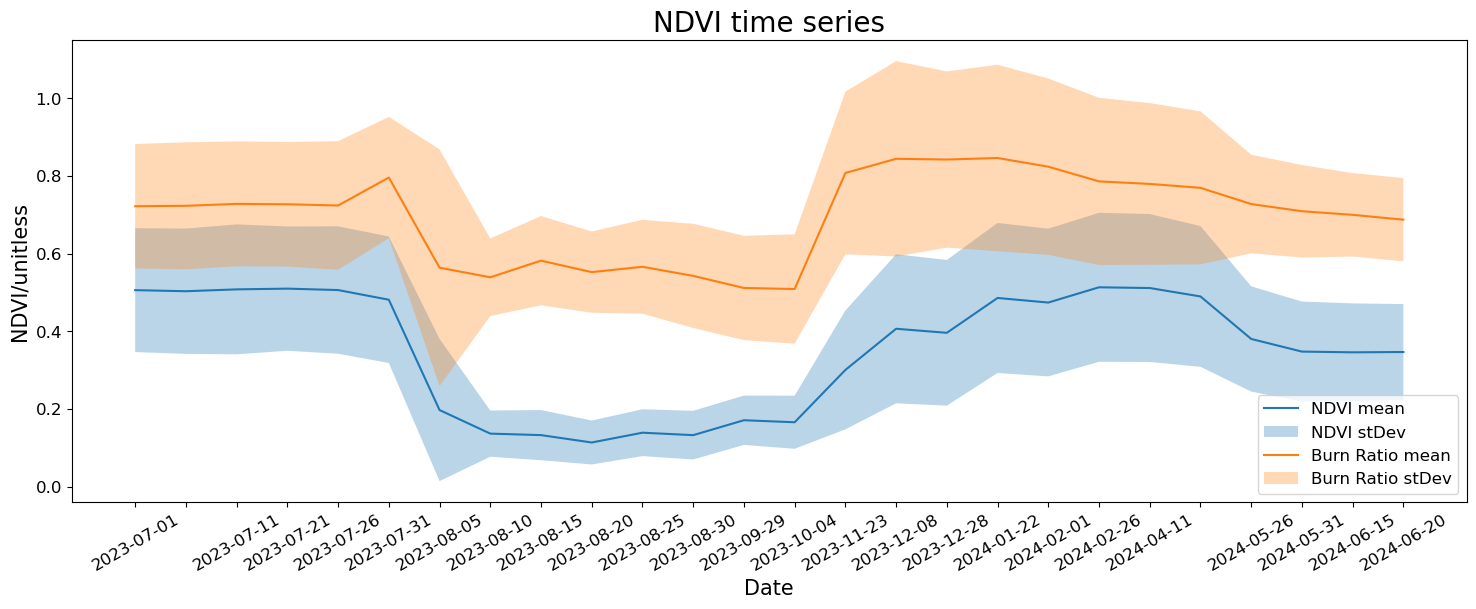

In [26]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))
t1 = result_df1["date"]
t2 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndvi_mean_field2 = result_df1["burnratio_max"]
ndvi_std_field2 = result_df1["burnratio_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)
ax_stat.plot(t2, ndvi_mean_field2, label="Burn Ratio mean")
ax_stat.fill_between(
    t2,
    ndvi_mean_field2 - ndvi_std_field2,
    ndvi_mean_field2 + ndvi_std_field2,
    alpha=0.3,
    label="Burn Ratio stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

## 7. Exercise: Compare burned area with an area of unburned vegetation

Now that you have learned how you visualise time series derived from statistical API, you can apply your knowledge to try some different comparisons; here are some hints on what you could try out:
- create another AOI - you can visit the Request Builder application, draw an AOI and then download it there. 
- put together a new request with the new AOI
- change the date range and/or the interval period. try changing the cloud cover percentage used.
- update the previous cell to plot the two AOIs onto the same plot.